In [2]:
import pandas as pd
from utils import *
from Bio import SeqIO
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
ref_path = '/home/tobamo/analize/2022-01-03_diamond_1000plant/baza/identical_protein_groups_tobamovirus_2.fasta'


replacements = {
    'RNA-dependent_RNA_polymerase': 'rdrp',
    'readthrough': 'rdrp',
    'coat': 'coat',
    'movement': 'movement',
    'transport': 'movement',
    'MP': 'movement'
}

data = []
with open(ref_path, 'r') as fin:
    for record in SeqIO.parse(fin, 'fasta'):
        description = record.id
        
        protein = next((v for k, v in replacements.items() if k in description), 'other')
        
        data.append({
            'ref_name':record.id,
            'seq_len': len(str(record.seq)),
            'protein': protein,
            # 'seq': str(record.seq)
        })

    ref_df = pd.DataFrame(data)
    
    def get_len_type(seq_len):
        # List of conditions with corresponding labels
        conditions = [
            (1116 <= seq_len <= 1160, 'orf1'),
            (seq_len > 1160, 'rdrp'),
            (124 <= seq_len <= 208, 'coat'),
            (334 <= seq_len <= 501, 'orf2'),
            (216 <= seq_len <= 311, 'movement'),
        ]
        # Find and return the first condition that is True
        for condition, label in conditions:
            if condition:
                return label
        # Default to 'other' if no condition is met
        return 'other'

    ref_df['guess_protein_type_based_on_len'] = ref_df['seq_len'].apply(get_len_type)

pd.set_option('max_colwidth', 800)

In [5]:
ref_df.protein.value_counts()

other       1103
coat         509
movement     407
rdrp         158
Name: protein, dtype: int64

In [39]:
raw = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/results_add_nr_taxa/megan6_results_combined_add_nr_taxa_non_cellular.csv')
getorf_path = '/home/tobamo/analize/project-tobamo/analysis/whole_orf/results/getorf_output_find1_min_360_max_3510_non_cellular.fasta'
getorf_all_path = '/home/tobamo/analize/project-tobamo/analysis/whole_orf/results/getorf_output_find1_min_360_max_3510.fasta'

In [14]:
df = raw[['SRR', 'qseqid', 'tpdb2_pident', 'tpdb2_length','tpdb2_qstart', 'tpdb2_qend', 'tpdb2_sstart', 'tpdb2_send','tpdb2_evalue', 'tpdb2_sseqid']].dropna(subset='tpdb2_pident')
df['orientation'] = df.apply(lambda row: 'FORWARD' if row['tpdb2_qstart'] < row['tpdb2_qend'] else 'REVERSE', axis=1)
df["reading_frame"] = df['tpdb2_qstart'].astype(int) % 3

In [15]:
def parse_fasta_to_df(fasta_path):
    # Step 1: Extract data from the FASTA file
    data = []
    with open(fasta_path, "r") as file:
        for record in SeqIO.parse(file, "fasta"):
            description = record.description
            seq = str(record.seq)
            data.append({
                'orf_name': description.split()[0],
                'orf_start': int(description.split('[')[1].split(' - ')[0]),
                'orf_end': int(description.split(' - ')[1].split(']')[0]),
                'orientation': 'REVERSE' if "(REVERSE SENSE)" in description else 'FORWARD',
                'seq': seq
            })
    
    # Step 2: Create DataFrame from extracted data
    df = pd.DataFrame(data)

    # Step 3: Add additional information
    def remove_last_number(s):
        return re.sub(r"_(\d+)$", "", s)

    df["qseqid"] = df["orf_name"].apply(lambda x: remove_last_number(x))
    # df["SRR"] = df["qseqid"].str.extract(r"_([A-Za-z0-9]+)$")
    df["seq_len"] = df["seq"].apply(len)
    df["reading_frame"] = df['orf_start'] % 3
    
    df['orf_num'] = df['orf_name'].str.extract(r'_(\d+)$')[0]
    max_orf_num = df.groupby('qseqid')['orf_num'].transform('max')
    df['orf_num'] = max_orf_num

    # Order of the columns to maintain consistency
    columns = ["qseqid", "orf_name","orf_num", "seq_len", "orf_start", "orf_end", "orientation", "reading_frame", "seq" ]
    df = df[columns]
    
    return df

getorf = parse_fasta_to_df(getorf_path)

In [41]:
getorf_all = parse_fasta_to_df(getorf_all_path)

In [42]:
len(getorf), len(getorf_all)

(1535, 1737)

Text(0, 0.5, 'No. of entries')

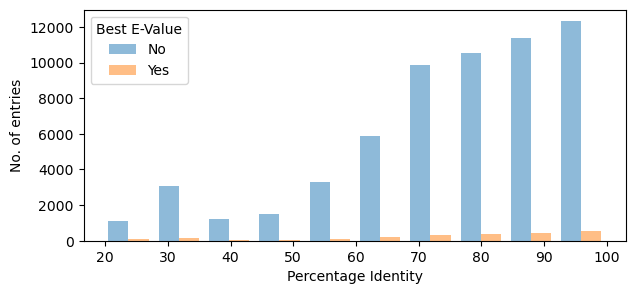

In [43]:
all_data = df.tpdb2_pident
best_evalue_data = df.loc[df.groupby('qseqid')['tpdb2_evalue'].idxmin()].tpdb2_pident

fig, ax = plt.subplots(figsize=(7,3))
plt.hist([all_data, best_evalue_data], alpha=0.5);
ax.legend(title='Best E-Value', labels=['No', 'Yes'])

ax.set_xlabel("Percentage Identity")
ax.set_ylabel("No. of entries")

In [44]:
best_evalue_df = df.loc[df.groupby('qseqid')['tpdb2_evalue'].idxmin()]

#### FILTER GETORF based on reading frame and orientation

In [48]:
def filter_getorf_output(getorf_df, tpdb2_diamond):
    filtered_df = getorf_df.merge(tpdb2_diamond, on=['qseqid', 'reading_frame', 'orientation'], how='inner')
    aggregated_df = filtered_df.groupby(['qseqid', 'orf_name', 'seq_len', 'orf_start', 'orf_end', 'reading_frame','orientation', 'SRR', 'seq'], as_index=False).agg({'tpdb2_sseqid': lambda x: ','.join(x)})
    return aggregated_df

filtered_getorf_orientation_reading_frame = filter_getorf_output(getorf, df)

In [49]:
len(filtered_getorf_orientation_reading_frame)

991

In [50]:
def filter_getorf_output(getorf_df, tpdb2_diamond):
    filtered_df = getorf_df.merge(tpdb2_diamond, on=['qseqid', 'orientation'], how='inner')
    aggregated_df = filtered_df.groupby(['qseqid', 'orf_name', 'seq_len', 'orf_start', 'orf_end', 'orientation', 'SRR', 'seq'], as_index=False).agg({'tpdb2_sseqid': lambda x: ','.join(x)})
    return aggregated_df

filtered_getorf = filter_getorf_output(getorf, df)
filtered_getorf.to_csv('filtered_getorf_orientation_only.csv', index=False)

In [52]:
filtered_getorf.qseqid.nunique()
len(filtered_getorf)

1256

<Axes: xlabel='seq_len', ylabel='Density'>

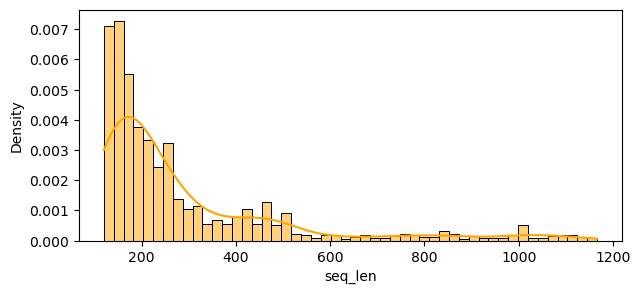

In [31]:
filtered_getorf_best_evalue = filter_getorf_output(getorf, best_evalue_df)
seq_len = filtered_getorf_best_evalue.seq_len

# Create subplots
fig, ax = plt.subplots(figsize=(7, 3))

# Plot KDE with a histogram
sns.histplot(seq_len, kde=True, stat='density', ax=ax, color='orange', bins=50, label='Original Data')  # Adjust 'bins' as needed


In [32]:
difference_df = getorf.merge(filtered_getorf, how='outer', indicator=True)
# Keep only the rows from df1 that are not in df2
difference_df = difference_df[difference_df['_merge'] == 'left_only']
# Drop the indicator column
difference_df.drop('_merge', axis=1, inplace=True)

In [33]:
len(getorf.seq_len), len(filtered_getorf.seq_len)

(1535, 1256)

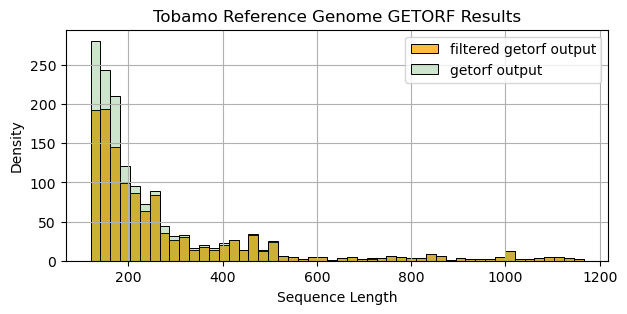

In [53]:
# Define the data for the KDE plot
seq_len1 = filtered_getorf.seq_len  # Assuming this is a list or a Pandas Series
seq_len2 = difference_df.seq_len
seq_len0 = getorf.seq_len

# Create subplots
fig, ax = plt.subplots(figsize=(7, 3))


# # Add vertical lines
# vertical_lines = [1115.04, 272.81, 463.94, 160.74]  # List of x-values for vertical lines
# for x in vertical_lines:
#     ax.axvline(x=x, color='black', linestyle='--', linewidth=1.5)


# Find the common min and max for both datasets
common_min = min(min(seq_len0), min(seq_len1))
common_max = max(max(seq_len0), max(seq_len1))

num_bins = 50
bin_edges = np.linspace(common_min, common_max, num_bins + 1)  # +1 to get 50 bins

# Plot KDE with a histogram
# sns.histplot(seq_len1, kde=True, stat='density', ax=ax, color='orange', bins=50, label='Original Data')  # Adjust 'bins' as needed
sns.histplot(seq_len1, ax=ax, color='orange', bins=bin_edges, label='filtered getorf output')  # Adjust 'bins' as needed

# sns.histplot(seq_len2, kde=True, stat='density', ax=ax, color='blue', bins=50, label='Difference Data', alpha=0.2)

# sns.histplot(seq_len0, kde=True, stat='density', ax=ax, color='green', bins=50, label='Difference Data', alpha=0.2)
sns.histplot(seq_len0, ax=ax, color='green', bins=bin_edges, label='getorf output', alpha=0.2)

ax.legend()

# Set plot title
ax.set_title('Tobamo Reference Genome GETORF Results')

# Label x and y axes
ax.set_xlabel('Sequence Length')
ax.set_ylabel('Density')

# Add grid lines for better readability
ax.grid(True)

# Show the plot
plt.show()

In [61]:
df[df.qseqid == 'NODE_9391_length_2399_cov_2.087855_SRR12681654']

,SRR,qseqid,tpdb2_pident,tpdb2_length,tpdb2_qstart,tpdb2_qend,tpdb2_sstart,tpdb2_send,tpdb2_evalue,tpdb2_sseqid,orientation,reading_frame
2731,SRR12681654,NODE_9391_length_2399_cov_2.087855_SRR12681654,26.0,235.0,995.0,309.0,1295.0,1525.0,5.600000e-12,AFT83336.1_replicase_read-through_product_[Youcai_mosaic_virus],REVERSE,2
2732,SRR12681654,NODE_9391_length_2399_cov_2.087855_SRR12681654,25.5,235.0,995.0,309.0,1295.0,1525.0,7.400000e-12,QMU26257.1_replicase_[Youcai_mosaic_virus],REVERSE,2
2733,SRR12681654,NODE_9391_length_2399_cov_2.087855_SRR12681654,26.0,235.0,995.0,309.0,1295.0,1525.0,7.400000e-12,AVK94642.1_replicase_read-through_product_[Youcai_mosaic_virus],REVERSE,2
2734,SRR12681654,NODE_9391_length_2399_cov_2.087855_SRR12681654,25.5,235.0,995.0,309.0,1295.0,1525.0,7.400000e-12,"AAP79445.1_RNA_replicase,_read-through_component_[Youcai_mosaic_virus]",REVERSE,2
2735,SRR12681654,NODE_9391_length_2399_cov_2.087855_SRR12681654,25.5,235.0,995.0,309.0,1295.0,1525.0,7.400000e-12,AAK53541.1_RNA_replicase_read-through_component_[Youcai_mosaic_virus],REVERSE,2
2736,SRR12681654,NODE_9391_length_2399_cov_2.087855_SRR12681654,25.5,235.0,995.0,309.0,1295.0,1525.0,9.600000e-12,NP_740757.2_replicase_[Youcai_mosaic_virus],REVERSE,2
2737,SRR12681654,NODE_9391_length_2399_cov_2.087855_SRR12681654,25.5,235.0,995.0,309.0,1294.0,1524.0,9.600000e-12,2211419A_replicase_[Chinese_Rape_Mosaic_Virus],REVERSE,2
2738,SRR12681654,NODE_9391_length_2399_cov_2.087855_SRR12681654,25.1,235.0,995.0,309.0,166.0,396.0,9.600000e-12,AZJ51175.1_nonstructural_protein_[Youcai_mosaic_virus],REVERSE,2
2739,SRR12681654,NODE_9391_length_2399_cov_2.087855_SRR12681654,26.7,240.0,998.0,309.0,1302.0,1531.0,9.600000e-12,YP_009362087.1_protein_183_[Hoya_chlorotic_spot_virus],REVERSE,2
2740,SRR12681654,NODE_9391_length_2399_cov_2.087855_SRR12681654,25.5,235.0,995.0,309.0,529.0,759.0,1.300000e-11,"QQP18716.1_RNA_replicase_read-through_component,_partial_[Turnip_vein-clearing_virus]",REVERSE,2


In [54]:
filtered_getorf[filtered_getorf.seq_len > 501].sort_values(by='seq_len').head(60)

,qseqid,orf_name,seq_len,orf_start,orf_end,orientation,SRR,seq,tpdb2_sseqid
176,NODE_1925_length_3885_cov_77.464811_SRR8455905,NODE_1925_length_3885_cov_77.464811_SRR8455905_2,502,1816,3321,FORWARD,SRR8455905,MSIPESGSVIPDIGSLESLQELYDNAFPGNSLVDDEFDGYLVQTSDLTIDAQDSVIPIFSKDGVIESKPAIKSRVRTAMPARRVQCDRENLIAVVKRNWDTPDVSEIVNYDEIISSSVDKFFSTYTIPELVDSSEIFSESNAVEWFNKQIGSTKGKIIRSEDFLDEMNHSKYNFMIKCDVKPKLDLSPQSEYAALQTVIFHGKEKNFIWGPIFHELTIRLLQCLKPNVIVNTKLSADQLTERFAGLNHLYDLAWYEMDLSKYDKSQGYIHQQVEMEIWERLGLEKSLRDLWERGHVSTSFSDLKSGFRSWLMYQRKSGDVTTFIGNTLVNMVVLADSLPIDNGYFSMFGGDDSLIGFPKEDLPNLIDPCYRVASVWNFQCKLFQFNLPSFCGKVLLRDNLGWVLVPDPLKLITKLGATKALNEKELEEVRISYWDNYKGLDNFRVIQLLREYLIERYKVTVDPTIALCSLVKFLKSPEAFKTLFFVENLTDVVRDRSSIVWN,"YP_009130653.1_replicase_large_protein_[Plumeria_mosaic_virus],APD13852.1_replicase_large_protein_[Plumeria_mosaic_virus],YP_009553013.2_187_kDa_hypothetical_polymerase_[Opuntia_virus_2],QWT83775.1_RNA-dependent_RNA_polymerase_[Odontoglossum_ringspot_virus],BBD88544.1_183_kDa_readthrough_protein_[Odontoglossum_ringspot_virus],AAS87224.1_RNA-dependent_RNA_polymerase_readthrough_protein_[Odontoglossum_ringspot_virus],BAX00083.1_183_kDa_readthrough_protein_[Odontoglossum_ringspot_virus],AAZ81884.1_RdRp_readthrough_protein_[Odontoglossum_ringspot_virus],P89659.2_Replicase_large_subunit_[Odontoglossum_ringspot_virus_(isolate_Korean_Cy)],AAB49498.2_183_kDa_protein,_partial_[Odontoglossum_ringspot_virus],BBC15190.1_186_kDa_protein_[Hibiscus_latent_Singapore_virus],YP_008802584.1_183k_replicas..."
109,NODE_1499_length_5218_cov_11.485509_SRR8455909,NODE_1499_length_5218_cov_11.485509_SRR8455909_2,502,3182,4687,FORWARD,SRR8455909,MSIPESGSVIPDIGSLESLQELYDNAFPGNSLVDDEFDGYLVQTSDLTIDAQDSVIPIFSKDGVIESKPAIKSRVRTAMPARRVQCDRENLIAVVKRNWDTPDVSEIVNYDEIISSSVDKFFSTYTIPELVDSSEIFSESNAVEWFNKQIGSTKGKIIRSEDFLDEMNHSKYNFMIKCDVKPKLDLSPQSEYAALQTVIFHGKEKNFIWGPIFHELTIRLLQCLKPNVIVNTKLSADQLTERFAGLNHLYDLAWYEMDLSKYDKSQGYIHQQVEMEIWERLGLEKSLRDLWERGHVSTSFSDLKSGFRSWLMYQRKSGDVTTFIGNTLVNMVVLADSLPIDNGYFSMFGGDDSLIGFPKEDLPNLIDPCYRVASVWNFQCKLFQFNLPSFCGKVLLRDNLGWVLVPDPLKLITKLGATKALNEKELEEVRISYWDNYKGLDNFRVIQLLREYLIERYKVTVDPTIALCSLVKFLKSPEAFKTLFFVENLTDVVRDRSSIVWN,"QWT83775.1_RNA-dependent_RNA_polymerase_[Odontoglossum_ringspot_virus],BBD88544.1_183_kDa_readthrough_protein_[Odontoglossum_ringspot_virus],AAS87224.1_RNA-dependent_RNA_polymerase_readthrough_protein_[Odontoglossum_ringspot_virus],AAZ81884.1_RdRp_readthrough_protein_[Odontoglossum_ringspot_virus],P89659.2_Replicase_large_subunit_[Odontoglossum_ringspot_virus_(isolate_Korean_Cy)],AAB49498.2_183_kDa_protein,_partial_[Odontoglossum_ringspot_virus],AAK53541.1_RNA_replicase_read-through_component_[Youcai_mosaic_virus],AAP79445.1_RNA_replicase,_read-through_component_[Youcai_mosaic_virus],BAX00083.1_183_kDa_readthrough_protein_[Odontoglossum_ringspot_virus],AGW21597.1_replicase_[Youcai_mosaic_virus],AAB53794.1_polyprotein_[Odontoglossum_ringspot_virus],QMU26257.1_replicase_[Youcai_mosaic_vi..."
375,NODE_366_length_5229_cov_8.771351_SRR8455912,NODE_366_length_5229_cov_8.771351_SRR8455912_2,502,3182,4687,FORWARD,SRR8455912,MSIPESGSVIPDIGSLESLQELYDNAFPGNSLVDDEFDGYLVQTSDLTIDAQDSVIPIFSKDGVIESKPAIKSRVRTAMPARRVQCDRENLIAVVKRNWDTPDVSEIVNYDEIISSSVDKFFSTYTIPELVDSSEIFSESNAVEWFNKQIGSTKGKIIRSEDFLDEMNHSKYNFMIKCDVKPKLDLSPQSEYAALQTVIFHGKEKNFIWGPIFHELTIRLLQCLKPNVIVNTKLSADQLTERFAGLNHLYDLAWYEMDLSKYDKSQGYIHQQVEMEIWERLGLEKSLRDLWERGHVSTSFSDLKSGFRSWLMYQRKSGDVTTFIGNTLVNMVVLADSLPIDNGYFSMFGGDDSLIGFPKEDLPNLIDPCYRVASVWNFQCKLFQFNLPSFCGKVLLRDNLGWVLVPDPLKLITKLGATKALNEKELEEVRISYWDNYKGLDNFRVIQLLREYLIERYKVTVDPTIALCSLVKFLKSPEAFKTLFFVENLTDVVRDRSSIVWN,"QWT83775.1_RNA-dependent_RNA_polymerase_[Odontoglossum_ringspot_virus],BBD88544.1_183_kDa_readthrough_protein_[Odontoglossum_ringspot_virus],AAS87224.1_RNA-dependent_RNA_polymerase_readthrough_protein_[Odontoglossum_ringspot_virus],AAZ81884.1_RdRp_readthrough_protein_[Odontoglossum_ringspot_virus],P89659.2_Replicase_large_subunit_[Odontoglossum_ringspot_virus_(isolate_Korean_Cy)],AAB49498.2_183_kDa_protein,_part